In [1]:
import numpy as np
import sys
import pyopencl as cl
import pyopencl.array
import pyopencl.clrandom
import timeit
from IPython.display import Image

This is the Python + OpenCL verison of the WallpaperTranformer example.

It is using PyOpenCL and I even managed to try running it on my phone

In [94]:
platforms = cl.get_platforms()
print(platforms)
ctx = cl.Context(
        dev_type=cl.device_type.ALL,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print(ctx.devices)

[<pyopencl.Platform 'QUALCOMM Snapdragon(TM)' at 0xde763ed3>]
[<pyopencl.Device 'QUALCOMM Adreno(TM)' on 'QUALCOMM Snapdragon(TM)' at 0x777da640d0>]


The OpenCL api is asynchronous so it requires a queue to send work to the GPU. 
This is why the first thing we need is a [CommandQueue](https://documen.tician.de/pyopencl/runtime_queue.html?highlight=commandqueue#pyopencl.CommandQueue) to be created first.

In [95]:
queue = cl.CommandQueue(ctx)

In [96]:
%env PYOPENCL_COMPILER_OUTPUT=1

env: PYOPENCL_COMPILER_OUTPUT=1


PyOpenCL works with numpy arrays so I used [iamgeio](https://imageio.github.io/) to read the input images.

In [97]:
import imageio

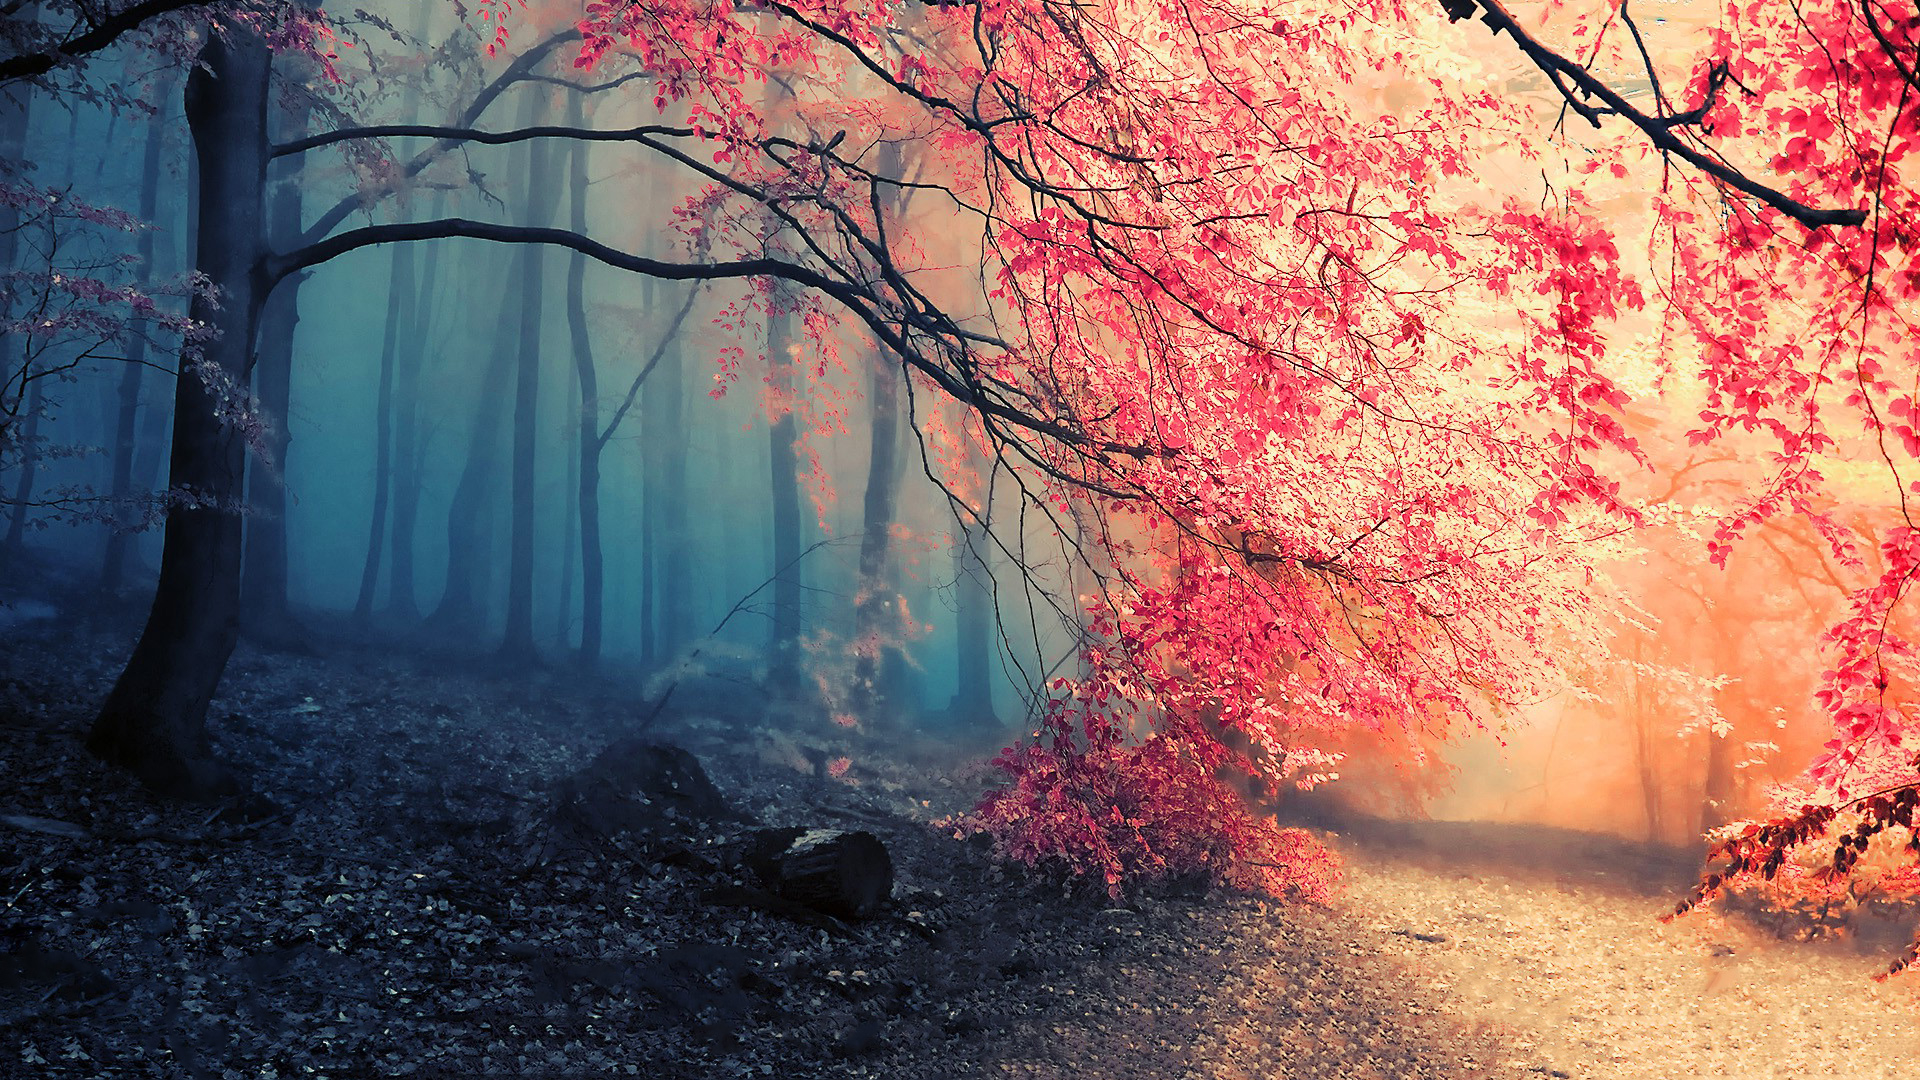

In [98]:
wallpaper = imageio.imread("./w1.jpg")
logo = imageio.imread("./logo1080.png")
Image(filename='w1.jpg') 

Having the images as numpy arrays is only half of the work that is needed, as the jpg file format doesn't hold the alpha channel I need to add it separatly, so the images is RGBA. and it's shape should be (1920, 1080, 4). 

In [99]:
wallpaper = np.insert(wallpaper, 3, 255, axis=2)

I use [cl.image_from_array](https://documen.tician.de/pyopencl/runtime_memory.html?highlight=image_from_array#pyopencl.image_from_array) as it solves the problem with layouting the image in memmory properly, as the image is not powers of 2, so it needs a stride and padding and this solves that for us.

In [100]:
mf = cl.mem_flags
fmt = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNORM_INT8)
fmt_logo = cl.ImageFormat(cl.channel_order.A, cl.channel_type.UNORM_INT8)


wallpaper_buffer = cl.image_from_array(ctx, wallpaper.copy(), 4, norm_int=True)
logo_buffer = cl.image_from_array(ctx, logo, 1, norm_int=True)
logo[490:500, 810:820]

Array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

The OpenCL c code for the transform. Using a [sampler_t](https://man.opencl.org/sampler_t.html) is a huge improveent over using buffers as that solves the problem with having to clamp the image thus reducing branches, and on top of that when [image2d_t](http://man.opencl.org/otherDataTypes.html) is used which places the image in the gpu's faster texture memmory. This is a prety standard gaussian blur implementation. in two stages.  

In [101]:
prg = cl.Program(ctx, """
constant sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_CLAMP | CLK_FILTER_LINEAR;

//float4 mix(float4 x, float4 y, float a) {
//    return  x + (y - x) * a;
//}

__kernel void blur_y(
    __constant float * mask,
    read_only image2d_t temp,
    read_only image2d_t original,
    read_only image2d_t logo,
    write_only image2d_t result
) 
{
  float3 res = (float3)(0,0,0);
  int2 pos = (int2)(get_global_id(0), get_global_id(1));
  for(int y = 0; y <= 6; y++) {
    float3 image = read_imagef(temp, sampler, (int2)(pos.x, pos.y + (y - 3))).xyz;
    res += mask[y] * image;
  }
  float3 orig = read_imagef(original, sampler, pos).xyz;
  float logo_mix = read_imagef(logo, sampler, pos).x;
  res = mix(res * 1.3, orig, logo_mix);
  write_imagef(result, (int2)(pos), (float4)(res, 0));  
 
}

kernel void blur_x(
    __constant float * mask,
    read_only image2d_t wallpaper,
    write_only image2d_t result
    )
{  
  int2 pos = (int2)(get_global_id(0), get_global_id(1));
  float3 res = (float3)(0,0,0);
  for(int x = 0; x <= 6; x++) {
    float3 image = read_imagef(wallpaper, sampler, (int2)(pos.x + (x - 3), pos.y)).xyz;
    res += mask[x] * image;
  }
  write_imagef(result, (int2)(pos), (float4)(res, 0));
}
""").build("")

Create the output and intermediate buffers. 

In [102]:
result = np.zeros(shape=(1080, 1920, 4), dtype=np.uint8)
result_buffer = cl.Image(ctx,
                         mf.WRITE_ONLY | mf.HOST_READ_ONLY,
                         fmt,
                         shape=(1920, 1080))

temp_buffer = cl.Image(ctx,
                         mf.READ_WRITE,
                         fmt,
                         shape=(1920, 1080))

Create the table, which is a const, and should be stored in the local memmory of each work item

In [103]:
table = np.array([0.129001,0.142521,0.151303,0.15435,0.151303,0.142521,0.129001], dtype=np.float32)
table_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=table)

Do all the compute, first we do blue in x direction then in y this way it is faster.

In [104]:
def do():
    bx = prg.blur_x(queue, (1920, 1080), None, table_buffer, wallpaper_buffer, temp_buffer)
    by = prg.blur_y(queue, (1920, 1080), None, table_buffer, temp_buffer, wallpaper_buffer, logo_buffer, result_buffer)
    cl.enqueue_copy(queue, result, result_buffer, origin=(0, 0), region=(1920, 1080), wait_for=[bx, by]).wait()    

# do()
r = np.array(timeit.repeat(do, number=1, repeat=60))


In [123]:
np.sum(r)/60

0.030410365433302406

I know this is a strange benchmark, but this number means that one frame is rendered for 30ms on the adreno gpu, this means that 30fps should be sustanable, but this doesn't include the bufer copyes so it might be slower.
This isn't an optimized approach and is blurring the whole image and then it mixes it with the stencil. It might be possible to reduce the computations needed and achieve better performance. Here is a result.

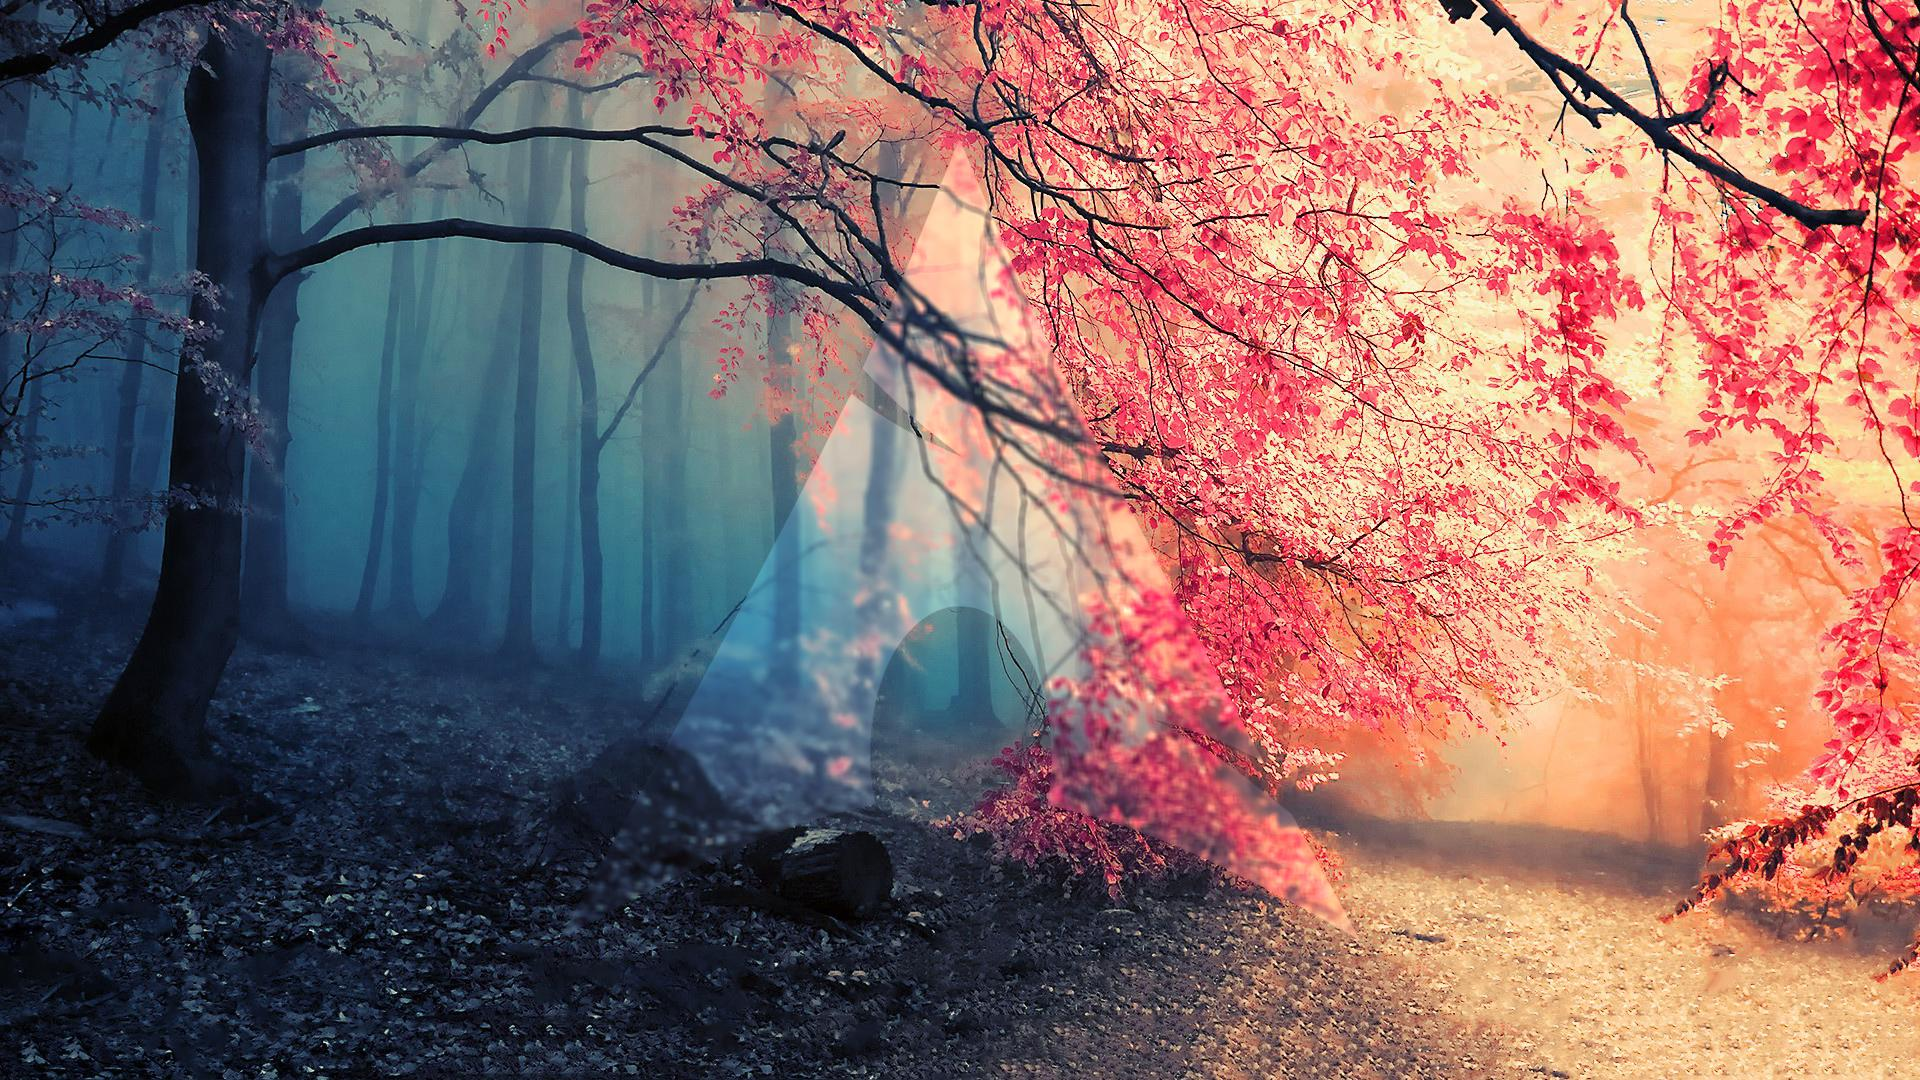

In [124]:
imageio.imwrite("res.jpg", result[:,:,0:3])
Image("res.jpg") 

In [125]:
result[1079, 1919].astype(np.float32) / 1

array([242., 192., 133.,   0.], dtype=float32)

In [108]:
wallpaper[10, 7:13].astype(np.float)/255

array([[0.06666667, 0.05882353, 0.07058824, 1.        ],
       [0.06666667, 0.05882353, 0.07058824, 1.        ],
       [0.03921569, 0.03921569, 0.04705882, 1.        ],
       [0.03529412, 0.03529412, 0.04313725, 1.        ],
       [0.04705882, 0.04313725, 0.0627451 , 1.        ],
       [0.04705882, 0.05098039, 0.07058824, 1.        ]])

In [109]:
np.array(wallpaper.shape[0:2])/12

array([ 90., 160.])